# Treecor test

In [2]:
from astropy.io import fits
from astropy.cosmology import LambdaCDM
import numpy as np
import matplotlib.pyplot as plt
import treecorr
from tqdm import tqdm
from perfiles import lenscat_load
#from pandas import DataFrame

## Functions

In [3]:
def make_randoms(ra, dec, z, size_random, col_names=['ra','dec','g1','g2','z']):
    
    print('Making randoms...')

    dec = np.deg2rad(dec)
    sindec_rand = np.random.uniform(np.sin(dec.min()), np.sin(dec.max()), size_random)
    dec_rand = np.arcsin(sindec_rand)*(180/np.pi)
    ra_rand  = np.random.uniform(ra.min(), ra.max(), size_random)

    y,xbins  = np.histogram(z, 25)
    x  = xbins[:-1]+0.5*np.diff(xbins)
    n = 3
    poly = np.polyfit(x,y,n)
    zr = np.random.uniform(z.min(),z.max(),1_000_000)
    poly_y = np.poly1d(poly)(zr)
    poly_y[poly_y<0] = 0.
    peso = poly_y/sum(poly_y)
    z_rand = np.random.choice(zr,size_random,replace=True,p=peso)

    randoms = {col_names[0]: ra_rand, col_names[1]: dec_rand, col_names[-1]:z_rand}
    
    print('Wii randoms!')
    
    return randoms

In [4]:
h = 1.0
cosmo = LambdaCDM(H0=100*h, Om0=0.25, Ode0=0.75)
def compute_xi_2d(positions, random_positions,
                  npi = 16, nbins = 12,
                  rmin = 0.1, rmax = 200., pi_max = 60.,
                  NPatches = 16, slop = 0.,
                  cosmo = cosmo, ncores = 4):

    ## Auxiliary functions to compute the covariance
    def func(corrs):
        return corrs[0].weight*0.5
    
    def func2(corrs):
        return corrs[0].weight
    
    """ Compute the galaxy-shape correlation in 3D. """

    # arrays to store the output
    r         = np.zeros(nbins)
    mean_r    = np.zeros(nbins)
    mean_logr = np.zeros(nbins)

    xi    = np.zeros((npi, nbins))
    xi_jk = np.zeros((NPatches, npi, nbins))
    dd_jk = np.zeros_like(xi_jk)
    dr_jk = np.zeros_like(xi_jk)
    rr_jk = np.zeros_like(xi_jk)

    d_p  = cosmo.comoving_distance(positions['z']).value
    d_r = cosmo.comoving_distance(random_positions['z']).value

    print('Loading catalogs...')
    
    pcat = treecorr.Catalog(ra=positions['ra'], dec=positions['dec'],
                             r=d_p, npatch = NPatches,
                             ra_units='deg', dec_units='deg')

    rcat = treecorr.Catalog(ra=random_positions['ra'], dec=random_positions['dec'],
                             r=d_r, npatch = NPatches,
                             patch_centers = pcat.patch_centers,
                             ra_units='deg', dec_units='deg')

    Nd = pcat.sumw
    Nr = rcat.sumw
    NNpairs = (Nd*(Nd - 1))/2.
    RRpairs = (Nr*(Nr - 1))/2.
    NRpairs = (Nd*Nr)

    f0 = RRpairs/NNpairs
    f1 = RRpairs/NRpairs

    Pi = np.linspace(-1.*pi_max, pi_max, npi+1)
    pibins = zip(Pi[:-1],Pi[1:])

    # now loop over Pi bins, and compute w(r_p | Pi)
    #bar = progressbar.ProgressBar(maxval=npi-1, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    #bar.start()
    print('Calcualting correlation...')
    for p,(plow,phigh) in enumerate(tqdm(pibins)):

        #bar.update(p)
        dd = treecorr.NNCorrelation(nbins=nbins, min_sep=rmin, max_sep=rmax,
                                    min_rpar=plow, max_rpar=phigh,
                                    bin_slop=slop, brute = False, verbose=0, var_method = 'jackknife')
        
#         dr = treecorr.NNCorrelation(nbins=nbins, min_sep=rmin, max_sep=rmax,
#                                     min_rpar=plow, max_rpar=phigh,
#                                     bin_slop=slop, brute = False, verbose=0, var_method = 'jackknife')
        
        rr = treecorr.NNCorrelation(nbins=nbins, min_sep=rmin, max_sep=rmax,
                                    min_rpar=plow, max_rpar=phigh,
                                    bin_slop=slop, brute = False, verbose=0, var_method = 'jackknife')

        dd.process(pcat,pcat, metric='Rperp', num_threads = ncores)
        # dr.process(pcat,rcat, metric='Rperp', num_threads = ncores)
        rr.process(rcat,rcat, metric='Rperp', num_threads = ncores)

        r[:] = np.copy(dd.rnom)
        mean_r[:] = np.copy(dd.meanr)
        mean_logr[:] = np.copy(dd.meanlogr)

        # xi[p, :] = (dd.weight*0.5*f0 - (2.*dr.weight)*f1 + rr.weight*0.5) / (rr.weight*0.5)

        xi[p,:], _ = dd.calculateXi(rr=rr)
        
        #Here I compute the variance
        dd_jk[:, p, :], weight = treecorr.build_multi_cov_design_matrix([dd], 'jackknife', func = func)
        # dr_jk[:, p, :], weight = treecorr.build_multi_cov_design_matrix([dr], 'jackknife', func = func2)
        rr_jk[:, p, :], weight = treecorr.build_multi_cov_design_matrix([rr], 'jackknife', func = func)

        # dd.finalize()
        # dr.finalize()
        # rr.finalize()

    for i in range(NPatches):

        swd = np.sum(pcat.w[~(pcat.patch == i)])
        swr = np.sum(rcat.w[~(rcat.patch == i)])

        NNpairs_JK = (swd*(swd - 1))/2.
        RRpairs_JK = (swr*(swr - 1))/2.
        NRpairs_JK = (swd*swr)

        xi_jk[i, :, :] = (dd_jk[i, :, :]/NNpairs_JK - (2.*dr_jk[i, :, :])/NRpairs_JK + rr_jk[i, :, :]/RRpairs_JK) / (rr_jk[i, :, :]/RRpairs_JK)

    xi[np.isinf(xi)] = 0. #It sets to 0 the values of xi_gp that are infinite
    xi[np.isnan(xi)] = 0. #It sets to 0 the values of xi_gp that are null

    xPi=(Pi[:-1]+Pi[1:])/2 #It returns an array going from -9.5,-8.5,...,8.5,9.5

    return r, mean_r, mean_logr, xPi, xi, xi_jk

In [5]:
def compute_wprp(positions, random_positions,
                  npi = 16, nbins = 12,
                  rmin = 0.1, rmax = 100., pi_max = 60.,
                  NPatches = 16, slop = 0.,
                  cosmo = cosmo, ncores = 4):
    
    r, mean_r, mean_logr, xPi, xi, xi_jk = compute_xi_2d(positions, random_positions,
                                                         npi, nbins, rmin, rmax, pi_max,
                                                         NPatches, slop,
                                                         cosmo, ncores)

    wprp = np.trapz(xi,xPi,axis=0)
    wprp_JK = np.trapz(xi_jk,xPi,axis=1)
    wprp_mean = np.mean(wprp_JK, axis = 0)
    wprp_diff = wprp_JK - wprp_mean
    cov_JK = ((NPatches-1)/NPatches)*np.sum(np.einsum('ij,ik->ijk',wprp_diff,wprp_diff), axis = 0)
    sigma = np.sqrt(np.diagonal(cov_JK))
    print('End!')
    
    result = {'rp':r, 'wprp':wprp, 'sigma':sigma, 'cov_JK':cov_JK, 'xPi':xPi, 'xi':xi, 'xi_jk':xi_jk, 'wprp_JK':wprp_JK}
    return result

## Computation CENTRALES

In [9]:
mparticle = 2.93e10 # Msun/h
with fits.open('../../cats/MICE/mice_sats_18939.fits') as f:
    mr_gal = f[1].data.mr_gal
    flag_central = f[1].data.flag_central
    lmhalo = f[1].data.lmhalo
    mask_particles = (lmhalo > np.log10(10*mparticle))
    mask_central = (flag_central == 0)
    mask_mr = (mr_gal < -19.4) ## igual q satelites, probablemente no sea el corte d completitud
    mask_particles = (lmhalo > np.log10(10*mparticle))
    ra_gal = f[1].data.ra_gal[mask_particles]
    dec_gal = f[1].data.dec_gal[mask_particles]
    z_gal = f[1].data.z_cgal[mask_particles]
    # lmhalo = lmhalo[mask_particles]
del lmhalo, mask_particles

In [10]:
ang_pos  = {'ra':ra_gal, 'dec':dec_gal, 'z':z_gal}
rand_pos = make_randoms(ra_gal, dec_gal, z_gal, 2*len(ra_gal))
# print(min(ang_pos['z']))

Making randoms...
Wii randoms!


In [11]:
centrals = compute_wprp(ang_pos, rand_pos,                  
                       npi = 16, nbins = 12,
                       rmin = 0.5, rmax = 40., pi_max = 40.,
                       NPatches = 16, slop = 0.,
                       cosmo = cosmo, ncores = 128)

Loading catalogs...
Calcualting correlation...


0it [08:31, ?it/s]


ValueError: Input arrays have zero length

In [ ]:
## Data from Castander et al 2015, fig 7 CENTRALS, blue points (from 0:12) and curve (from 12:end)
x = [0.16362394232879848, 0.27136158897271223, 0.43232790292450446, 0.6723821596295929, 1.1241002097037442, 1.652710035282339, 2.6330648578555755, 4.194946722453708, 6.901454754023999, 10.562553193329078, 16.82805031061228, 26.810116083992444, 0.1717002022336638, 0.25859755787530925, 0.41866240445113406, 0.6887762426313584, 1.0712259245568567, 1.6794663845324524, 2.6120063660439454, 4.1613967508525675, 6.683305939739347, 10.647710504897393, 16.693464427315682, 27.026264335912174]
y = [303.16243919534344, 215.01102669447923, 155.27426295355187, 106.21308186910859, 68.81709490982395, 46.22974160021408, 34.61521358815271, 24.110096735768753, 15.621303761763825, 10.685523690727539, 5.778034155045445, 2.7529008882327197, 71.35150554968166, 59.54826466561886, 46.22974160021408, 44.58765783356008, 32.787386958836635, 30.49953328868394, 22.836983781061825, 15.621303761763825, 11.487074139448831, 7.716752209681147, 4.485723092770268, 2.176187618710234]

In [ ]:
plt.errorbar(centrals['rp'], centrals['wprp'], centrals['sigma'],fmt='k.-', label='this')
plt.scatter(x[:12],y[:12], s=10.0, c='b', label='SDSS')
plt.plot(x[12:],y[12:], c='b', label='MICE-Paper')
# plt.xlim(-0.5,35)
# plt.ylim(0.1, 20_000)
plt.loglog()
# plt.axvline(10, ls='--',c='k',alpha=0.2)
# plt.axhline(wprp[8], ls='--',c='k',alpha=0.2)
# plt.text(1,wprp[8]+1,f'{wprp[8]:.2e}')
plt.legend()
plt.show()

In [ ]:
X, Y = np.meshgrid(centrals['rp'], centrals['xPi'])
levels = np.array([0.1,0.16,0.25,0.4,0.63,1.0,1.58])
fig, ax = plt.subplots(figsize=(5,5))
# plt.ylim(0,20)
# plt.xlim(0,20)
CS = ax.contour(X, Y, centrals['xi'],
                levels=levels)
ax.clabel(CS, inline=True, fontsize=9)
plt.minorticks_on()
plt.xlabel('$r_p$')
plt.ylabel('$\\pi$')
# plt.colorbar(CS)

## Computation SATELITES

In [ ]:
mparticle = 2.93e10 # Msun/h
with fits.open('../../cats/MICE/mice_sats_18939.fits') as f:
    mr_gal = f[1].data.mr_gal
    flag_central = f[1].data.flag_central
    lmhalo = f[1].data.lmhalo
    mask_particles = (lmhalo > np.log10(10*mparticle))
    mask_central = (flag_central == 1)
    mask_mr = (mr_gal < -19.4) ## la moda
    ra_gal = f[1].data.ra_gal[mask_particles & mask_central & mask_mr]
    dec_gal = f[1].data.dec_gal[mask_particles & mask_central & mask_mr]
    z_gal = f[1].data.z_cgal[mask_particles & mask_central & mask_mr]
    # lmhalo = lmhalo[mask_particles]
del lmhalo, mr_gal, mask_particles, mask_central, mask_mr

In [ ]:
## correction for ra >= 0
dec_gal = dec_gal[ra_gal>=0]
z_gal = z_gal[ra_gal>=0]
ra_gal = ra_gal[ra_gal>=0]

In [ ]:
ang_pos  = {'ra':ra_gal, 'dec':dec_gal, 'z':z_gal}
rand_pos = make_randoms(ra_gal, dec_gal, z_gal, 2*len(ra_gal))
# print(min(ang_pos['z']))

In [ ]:
sats =  compute_wprp(ang_pos, rand_pos,                  
                     npi = 16, nbins = 12,
                     rmin = 0.5, rmax = 40., pi_max = 40.,
                     NPatches = 16, slop = 0.,
                     cosmo = cosmo, ncores = 128)

In [ ]:
## Data from Castander et al 2015, fig 7 SATELLITES, blue points (0:12) and blue curve (12:end)
x = [0.16901240494408273, 0.2712232028868648, 0.4148070447816064, 0.6603480296554902, 1.0942262489864925, 1.6735026790974117, 2.7289630946591386, 4.241113914441934, 6.644215477804844, 10.408963353984879, 16.838260891620813, 26.591479484724942, 0.1717439999039328, 0.2690576498066018, 0.4215111966644853, 0.6656629452904628, 1.085489514817824, 1.6869721302880871, 2.7071739764249267, 4.140334694516944, 6.860719952013025, 10.577194034119962, 16.838260891620813, 26.591479484724942]
y = [311.9734581912619, 229.50085811539057, 157.06464294715556, 111.44454707535625, 70.95457321534288, 51.26298858667709, 34.45521005822682, 24.009999823403888, 15.848931924611142, 10.274594854461801, 5.661625992822727, 2.902318686521058, 1703.619290370081, 1276.0930781150919, 873.3261623828438, 536.3048996942866, 311.9734581912619, 181.47780986393235, 103.67791970603659, 63.668052926236896, 40.53620963418107, 25.346708405114487, 15.013107289081743, 7.031675547946471]

In [ ]:
plt.errorbar(sats['rp'], sats['wprp'], sats['sigma'],fmt='k.-')
plt.scatter(x[:12],y[:12], s=10.0, c='b', label='SDSS')
plt.plot(x[12:],y[12:], c='b', label='MICE-Paper')
# plt.xlim(-0.5,35)
# plt.ylim(0.1, 20_000)
plt.loglog()
# plt.axvline(10, ls='--',c='k',alpha=0.2)
# plt.axhline(wprp[8], ls='--',c='k',alpha=0.2)
# plt.text(1,wprp[8]+1,f'{wprp[8]:.2e}')
plt.legend()
plt.show()

In [ ]:
X, Y = np.meshgrid(sats['rp'], sats['xPi'])
levels = np.array([0.1,0.16,0.25,0.4,0.63,1.0,1.58])
fig, ax = plt.subplots(figsize=(5,5))
# plt.ylim(0,20)
# plt.xlim(0,20)
CS = ax.contour(X, Y, sats['xi'],
                levels=levels)
ax.clabel(CS, inline=True, fontsize=9)
plt.minorticks_on()
plt.xlabel('$r_p$')
plt.ylabel('$\\pi$')
# plt.colorbar(CS)

## Computation TOTAL

In [7]:
mparticle = 2.93e10 # Msun/h
with fits.open('../../cats/MICE/mice_sats_18939.fits') as f:
    mr_gal = f[1].data.mr_gal
    flag_central = f[1].data.flag_central
    lmhalo = f[1].data.lmhalo
    mask_particles = (lmhalo > np.log10(10*mparticle))
    mask_mr = (mr_gal < -19.4) ## la moda
    ra_gal = f[1].data.ra_gal[mask_particles & mask_mr]
    dec_gal = f[1].data.dec_gal[mask_particles & mask_mr]
    z_gal = f[1].data.z_cgal[mask_particles & mask_mr]
    # lmhalo = lmhalo[mask_particles]
del lmhalo, mr_gal, mask_particles, mask_mr

In [8]:
## correction for ra >= 0
dec_gal = dec_gal[ra_gal>=0]
z_gal = z_gal[ra_gal>=0]
ra_gal = ra_gal[ra_gal>=0]

In [9]:
ang_pos  = {'ra':ra_gal, 'dec':dec_gal, 'z':z_gal}
rand_pos = make_randoms(ra_gal, dec_gal, z_gal, 2*len(ra_gal))
# print(min(ang_pos['z']))

Making randoms...
Wii randoms!


(array([0.0815723 , 0.25267055, 0.42853529, 0.60916811, 0.77327672,
        0.92577128, 1.04469079, 1.12321527, 1.1681659 , 1.1490565 ]),
 array([0.0936498 , 0.22599281, 0.35833582, 0.49067882, 0.62302183,
        0.75536484, 0.88770784, 1.02005085, 1.15239386, 1.28473686,
        1.41707987]),
 [<matplotlib.patches.Polygon at 0x7f7df5306a40>])

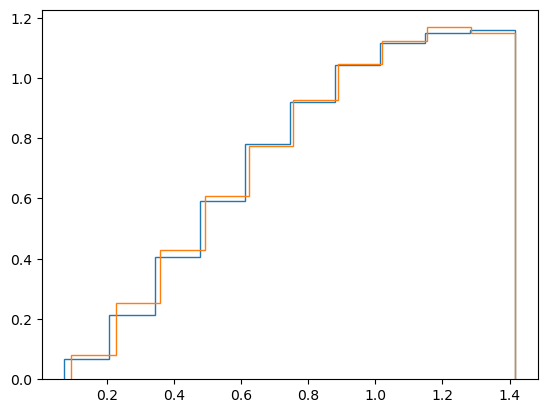

In [10]:
plt.hist(ang_pos['z'], histtype='step', density=True)
plt.hist(rand_pos['z'], histtype='step', density=True)

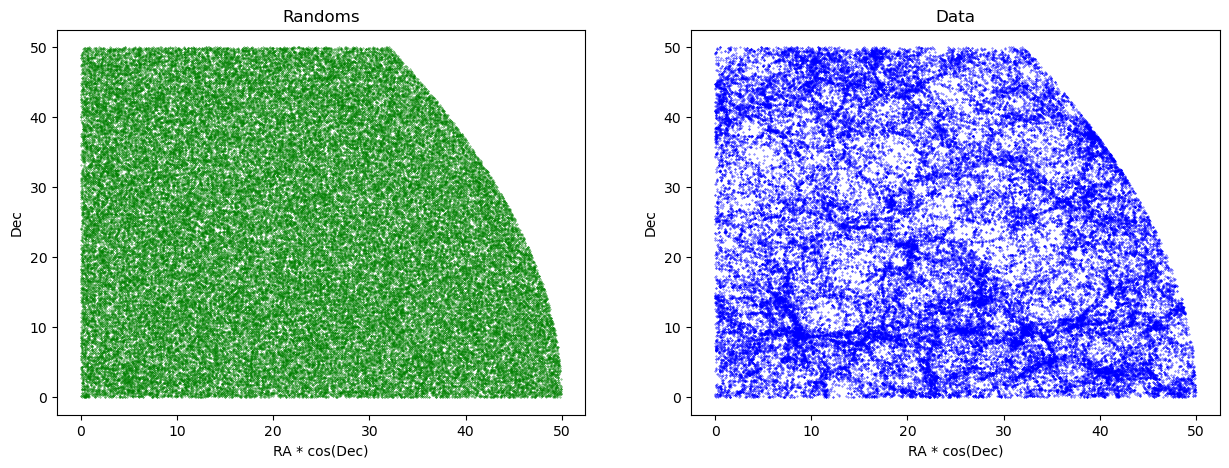

In [11]:
amin, amax = 0,50
alpha = 0.9
maskz = (ang_pos['z'] > 0.1) & (ang_pos['z'] <= 0.13)
maskzr = (rand_pos['z'] > 0.1) & (rand_pos['z'] <= 0.13)
mran = (rand_pos['ra'] > amin) & (rand_pos['ra'] < amax) & (rand_pos['dec'] > amin) & (rand_pos['dec'] < amax)
mtru = (ang_pos['ra'] > amin) & (ang_pos['ra'] < amax) & (ang_pos['dec'] > amin) & (ang_pos['dec'] < amax)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.scatter(rand_pos['ra'][maskzr & mran] * np.cos(rand_pos['dec'][maskzr & mran]*np.pi/180), rand_pos['dec'][maskzr & mran], color='green', s=0.1, alpha=alpha)
ax1.set_xlabel('RA * cos(Dec)')
ax1.set_ylabel('Dec')
# ax1.set_xlim(3,5)
# ax1.set_ylim(83,85)
ax1.set_title('Randoms')

ax2.scatter(ang_pos['ra'][maskz & mtru] * np.cos(ang_pos['dec'][maskz & mtru]*np.pi/180), ang_pos['dec'][maskz & mtru], color='blue', s=0.1, alpha=alpha)
ax2.set_xlabel('RA * cos(Dec)')
ax2.set_ylabel('Dec')
# ax2.set_xlim(5,35)
# ax2.set_ylim(5,35)
ax2.set_title('Data')

plt.show()

In [ ]:
totals =  compute_wprp(ang_pos, rand_pos,                  
                     npi = 16, nbins = 12,
                     rmin = 0.5, rmax = 40., pi_max = 40.,
                     NPatches = 16, slop = 0.,
                     cosmo = cosmo, ncores = 128)

Loading catalogs...


In [ ]:
## Data from Castander et al 2015, fig 7 SATELLITES, blue points (0:12) and blue curve (12:end)
# x = [0.16901240494408273, 0.2712232028868648, 0.4148070447816064, 0.6603480296554902, 1.0942262489864925, 1.6735026790974117, 2.7289630946591386, 4.241113914441934, 6.644215477804844, 10.408963353984879, 16.838260891620813, 26.591479484724942, 0.1717439999039328, 0.2690576498066018, 0.4215111966644853, 0.6656629452904628, 1.085489514817824, 1.6869721302880871, 2.7071739764249267, 4.140334694516944, 6.860719952013025, 10.577194034119962, 16.838260891620813, 26.591479484724942]
# y = [311.9734581912619, 229.50085811539057, 157.06464294715556, 111.44454707535625, 70.95457321534288, 51.26298858667709, 34.45521005822682, 24.009999823403888, 15.848931924611142, 10.274594854461801, 5.661625992822727, 2.902318686521058, 1703.619290370081, 1276.0930781150919, 873.3261623828438, 536.3048996942866, 311.9734581912619, 181.47780986393235, 103.67791970603659, 63.668052926236896, 40.53620963418107, 25.346708405114487, 15.013107289081743, 7.031675547946471]

In [ ]:
plt.errorbar(totals['rp'], totals['wprp'], totals['sigma'],fmt='k.-')
# plt.scatter(x[:12],y[:12], s=10.0, c='b', label='SDSS')
# plt.plot(x[12:],y[12:], c='b', label='MICE-Paper')
# plt.xlim(-0.5,35)
# plt.ylim(0.1, 20_000)
plt.loglog()
# plt.axvline(10, ls='--',c='k',alpha=0.2)
# plt.axhline(wprp[8], ls='--',c='k',alpha=0.2)
# plt.text(1,wprp[8]+1,f'{wprp[8]:.2e}')
plt.legend()
plt.show()

In [ ]:
X, Y = np.meshgrid(totals['rp'], totals['xPi'])
levels = np.array([0.1,0.16,0.25,0.4,0.63,1.0,1.58])
fig, ax = plt.subplots(figsize=(5,5))
# plt.ylim(0,20)
# plt.xlim(0,20)
CS = ax.contour(X, Y, totals['xi'],
                levels=levels)
ax.clabel(CS, inline=True, fontsize=9)
plt.minorticks_on()
plt.xlabel('$r_p$')
plt.ylabel('$\\pi$')
# plt.colorbar(CS)